In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split,cross_val_score
#model selection from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#ensemble
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix
#pca
from sklearn.decomposition import PCA
#data_balance
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
#warnings
import warnings
warnings.filterwarnings("ignore")

In [17]:
import os
os.chdir(r'C:\Users\VISHY\Desktop\Great Learning\Capstone\Vehicle-Loan-Default-Prediction\Data')

df = pd.read_csv('train.csv')

df=df.drop(['UniqueID','MobileNo_Avl_Flag'],axis=1)

In [18]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d2

risk_map = {'No Bureau History Available':0, 
              'Not Scored: No Activity seen on the customer (Inactive)':0,
              'Not Scored: Sufficient History Not Available':0,
              'Not Scored: No Updates available in last 36 months':0,
              'Not Scored: Only a Guarantor':0,
              'Not Scored: More than 50 active Accounts found':0,
              'Not Scored: Not Enough Info available on the customer':0,
              'Very Low Risk':4,
              'Low Risk':3,
              'Medium Risk':2, 
              'High Risk':1,
              'Very High Risk':0}

sub_risk = {'unknown':0, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:2}

df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'sub_risk_label'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'employment_label'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk_grade','Employment.Type'],axis=1)

In [19]:
def duration(dur):
    yrs = int(dur.split(' ')[0].replace('yrs',''))
    mon = int(dur.split(' ')[1].replace('mon',''))
    return yrs*12+mon

In [20]:
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(duration)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(duration)
#df.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'],axis=1,inplace=True)

In [21]:
def age(dur):
    yr = int(dur.split('-')[2])
    if yr >=0 and yr<=19:
        return yr+2000
    else:
         return yr+1900

df['Date.of.Birth'] = df['Date.of.Birth'].apply(age)
df['DisbursalDate'] = df['DisbursalDate'].apply(age)
df['Age']=df['DisbursalDate']-df['Date.of.Birth']
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

In [7]:
dummies=['manufacturer_id']

In [9]:
df=pd.get_dummies(df,columns=dummies,drop_first=True)

In [10]:
df.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,Current_pincode_ID,State_ID,Employee_code_ID,Aadhar_flag,PAN_flag,...,manufacturer_id_48,manufacturer_id_49,manufacturer_id_51,manufacturer_id_67,manufacturer_id_86,manufacturer_id_120,manufacturer_id_145,manufacturer_id_152,manufacturer_id_153,manufacturer_id_156
0,50578,58400,89.55,67,22807,1441,6,1998,1,0,...,0,0,0,0,0,0,0,0,0,0
1,47145,65550,73.23,67,22807,1502,6,1998,1,0,...,0,0,0,0,0,0,0,0,0,0
2,53278,61360,89.63,67,22807,1497,6,1998,1,0,...,0,0,0,0,0,0,0,0,0,0
3,57513,66113,88.48,67,22807,1501,6,1998,1,0,...,0,0,0,0,0,0,0,0,0,0
4,52378,60300,88.39,67,22807,1495,6,1998,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'branch_id', 'supplier_id',
       'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'Aadhar_flag',
       'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'sub_risk_label', 'employment_label', 'Age',
       'manufacturer_id_48', 'manufacturer_id_49', 'manufacturer_id_51',
       'manufacturer_id_67', 'manufacturer_id_86', 'manufacturer_id_120',
       'manufacturer_id_145', 'manufacturer_id_152', 'ma

## Stats

In [10]:
x=df.drop('loan_default',axis=1)

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
feats=[]
vif=0
for i in range(x.shape[1]):
    vif=variance_inflation_factor(x.values, i)
    print(x.columns[i],"         ", vif)
    if (vif>10):
        feats.append(x.columns[i])
print(feats)

disbursed_amount           34.74096134329803
asset_cost           34.32358306832174
ltv           16.347967701981716
supplier_id           1.411587015448723
Current_pincode_ID           297.9056742424716
Employee_code_ID           1.176848887603842
Aadhar_flag           8.5728002704886
PAN_flag           1.230382067494454
VoterID_flag           7.349892470949365
Driving_flag           1.9069029854373136
Passport_flag           1.0878054143507911
PERFORM_CNS.SCORE           28.35773384610737
PRI.NO.OF.ACCTS           2.6904577281469986
PRI.ACTIVE.ACCTS           4.667306777256863
PRI.OVERDUE.ACCTS           1.918212598476091
PRI.CURRENT.BALANCE           1.563478754509351
PRI.SANCTIONED.AMOUNT           407.62506834109746
PRI.DISBURSED.AMOUNT           410.21066924891045
SEC.NO.OF.ACCTS           3.4513466159405195
SEC.ACTIVE.ACCTS           3.8546637887356163
SEC.OVERDUE.ACCTS           1.4327625670807622
SEC.CURRENT.BALANCE           7.60803420579862
SEC.SANCTIONED.AMOUNT           15

In [13]:
df=df.drop(['asset_cost','PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT'],axis=1)

In [14]:
df=df.drop(['PERFORM_CNS.SCORE'],axis=1)

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

In [32]:
df.columns

Index(['disbursed_amount', 'ltv', 'branch_id', 'manufacturer_id',
       'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'Aadhar_flag',
       'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'sub_risk_label', 'employment_label', 'Age'],
      dtype='object')

In [9]:
num_cols=['disbursed_amount','PRI.NO.OF.ACCTS','PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Age']
cat_cols=['branch_id', 'manufacturer_id',
       'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'Aadhar_flag',
       'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag','sub_risk_label', 'employment_label']

In [14]:
c = SelectKBest(score_func=chi2, k=12)
catcols = c.fit(df[cat_cols],df['loan_default'])
n = SelectKBest(score_func=f_classif, k=5)
numcols=n.fit(df[num_cols],df['loan_default'])

Text(0.5, 1.0, 'Best Numerical Features')

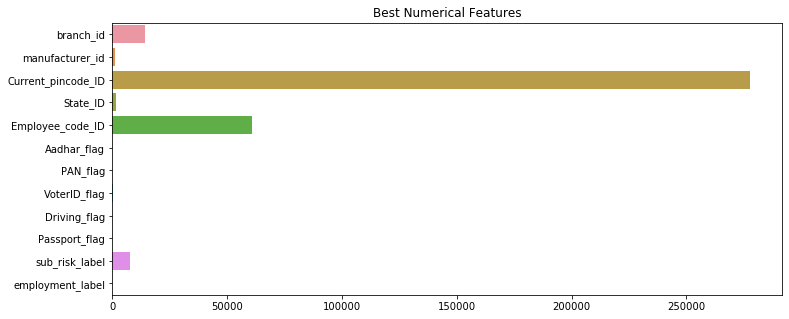

In [47]:
catsc=catcols.scores_
plt.figure(figsize=(12,5))
sns.barplot(x=catsc,y=cat_cols)
plt.title('Best Numerical Features')

In [125]:
cat_cols=['branch_id','supplier_id','manufacturer_id','Current_pincode_ID','State_ID','Employee_code_ID','PAN_flag','Driving_flag','Passport_flag','employment_label','Employee_code_ID','sub_risk_label']

In [15]:
list(df.columns)

['disbursed_amount',
 'asset_cost',
 'ltv',
 'supplier_id',
 'Current_pincode_ID',
 'Employee_code_ID',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'Driving_flag',
 'Passport_flag',
 'PERFORM_CNS.SCORE',
 'PRI.NO.OF.ACCTS',
 'PRI.ACTIVE.ACCTS',
 'PRI.OVERDUE.ACCTS',
 'PRI.CURRENT.BALANCE',
 'PRI.SANCTIONED.AMOUNT',
 'PRI.DISBURSED.AMOUNT',
 'SEC.NO.OF.ACCTS',
 'SEC.ACTIVE.ACCTS',
 'SEC.OVERDUE.ACCTS',
 'SEC.CURRENT.BALANCE',
 'SEC.SANCTIONED.AMOUNT',
 'SEC.DISBURSED.AMOUNT',
 'PRIMARY.INSTAL.AMT',
 'SEC.INSTAL.AMT',
 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'AVERAGE.ACCT.AGE',
 'CREDIT.HISTORY.LENGTH',
 'NO.OF_INQUIRIES',
 'loan_default',
 'credit_risk_label',
 'sub_risk_label',
 'Age',
 'branch_id_2',
 'branch_id_3',
 'branch_id_5',
 'branch_id_7',
 'branch_id_8',
 'branch_id_9',
 'branch_id_10',
 'branch_id_11',
 'branch_id_13',
 'branch_id_14',
 'branch_id_15',
 'branch_id_16',
 'branch_id_17',
 'branch_id_18',
 'branch_id_19',
 'branch_id_20',
 'b

In [16]:
cats=['supplier_id',
 'Current_pincode_ID',
 'Employee_code_ID',
 'Aadhar_flag',
 'PAN_flag',
 'VoterID_flag',
 'Driving_flag',
 'Passport_flag','credit_risk_label',
 'sub_risk_label','branch_id_2',
 'branch_id_3',
 'branch_id_5',
 'branch_id_7',
 'branch_id_8',
 'branch_id_9',
 'branch_id_10',
 'branch_id_11',
 'branch_id_13',
 'branch_id_14',
 'branch_id_15',
 'branch_id_16',
 'branch_id_17',
 'branch_id_18',
 'branch_id_19',
 'branch_id_20',
 'branch_id_29',
 'branch_id_34',
 'branch_id_35',
 'branch_id_36',
 'branch_id_42',
 'branch_id_43',
 'branch_id_48',
 'branch_id_61',
 'branch_id_62',
 'branch_id_63',
 'branch_id_64',
 'branch_id_65',
 'branch_id_66',
 'branch_id_67',
 'branch_id_68',
 'branch_id_69',
 'branch_id_70',
 'branch_id_72',
 'branch_id_73',
 'branch_id_74',
 'branch_id_76',
 'branch_id_77',
 'branch_id_78',
 'branch_id_79',
 'branch_id_82',
 'branch_id_84',
 'branch_id_85',
 'branch_id_97',
 'branch_id_100',
 'branch_id_101',
 'branch_id_103',
 'branch_id_104',
 'branch_id_105',
 'branch_id_111',
 'branch_id_117',
 'branch_id_120',
 'branch_id_121',
 'branch_id_130',
 'branch_id_135',
 'branch_id_136',
 'branch_id_138',
 'branch_id_142',
 'branch_id_146',
 'branch_id_147',
 'branch_id_152',
 'branch_id_153',
 'branch_id_158',
 'branch_id_159',
 'branch_id_160',
 'branch_id_162',
 'branch_id_165',
 'branch_id_202',
 'branch_id_207',
 'branch_id_217',
 'branch_id_248',
 'branch_id_249',
 'branch_id_250',
 'branch_id_251',
 'branch_id_254',
 'branch_id_255',
 'branch_id_257',
 'branch_id_258',
 'branch_id_259',
 'branch_id_260',
 'branch_id_261',
 'manufacturer_id_48',
 'manufacturer_id_49',
 'manufacturer_id_51',
 'manufacturer_id_67',
 'manufacturer_id_86',
 'manufacturer_id_120',
 'manufacturer_id_145',
 'manufacturer_id_152',
 'manufacturer_id_153',
 'manufacturer_id_156',
 'State_ID_2',
 'State_ID_3',
 'State_ID_4',
 'State_ID_5',
 'State_ID_6',
 'State_ID_7',
 'State_ID_8',
 'State_ID_9',
 'State_ID_10',
 'State_ID_11',
 'State_ID_12',
 'State_ID_13',
 'State_ID_14',
 'State_ID_15',
 'State_ID_16',
 'State_ID_17',
 'State_ID_18',
 'State_ID_19',
 'State_ID_20',
 'State_ID_21',
 'State_ID_22',
 'employment_label_1',
 'employment_label_2']

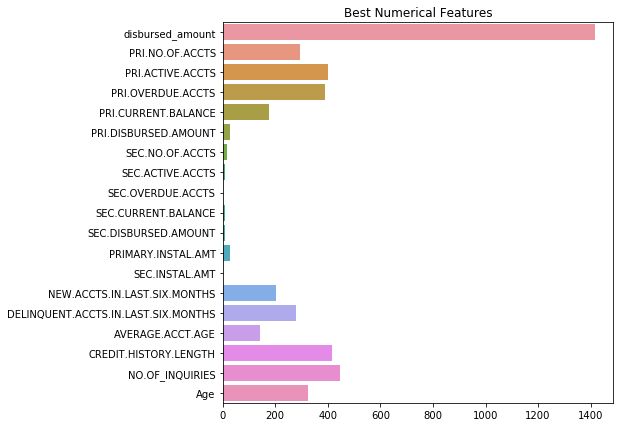

In [16]:
plt.figure(figsize=(7,7))
sns.barplot(x=numcols.scores_,y=num_cols)
plt.title('Best Numerical Features')
plt.show()

In [29]:
num_cols=['PRI.NO.OF.ACCTS','PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Age']

In [85]:
col=['branch_id','manufacturer_id','Current_pincode_ID','State_ID','Employee_code_ID','sub_risk_label','PRI.NO.OF.ACCTS','PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES','Age','loan_default']

In [86]:
df=df[col]

In [40]:
col

['branch_id',
 'manufacturer_id',
 'Current_pincode_ID',
 'State_ID',
 'Employee_code_ID',
 'sub_risk_label',
 'PRI.NO.OF.ACCTS',
 'PRI.ACTIVE.ACCTS',
 'PRI.OVERDUE.ACCTS',
 'PRI.CURRENT.BALANCE',
 'PRI.DISBURSED.AMOUNT',
 'PRIMARY.INSTAL.AMT',
 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'AVERAGE.ACCT.AGE',
 'CREDIT.HISTORY.LENGTH',
 'NO.OF_INQUIRIES',
 'Age']

In [19]:
from scipy.stats import chi2_contingency
chi=[]
for i in cats:
    pvalue  = chi2_contingency(pd.crosstab(df[i],df['loan_default']))[1]
    print(i,pvalue)
    if pvalue > 0.05:
        chi.append(i)

supplier_id 0.0
Current_pincode_ID 0.0
Employee_code_ID 0.0
Aadhar_flag 1.1791998402218374e-89
PAN_flag 0.3277743362589148
VoterID_flag 5.603683381655361e-99
Driving_flag 0.0052012912081583085
Passport_flag 0.0002987981770071958
credit_risk_label 0.0
sub_risk_label 0.0
branch_id_2 5.855057437325583e-18
branch_id_3 1.1982110297535957e-23
branch_id_5 0.24040722472401876
branch_id_7 0.06485872235031706
branch_id_8 6.890488768651472e-28
branch_id_9 0.0021518334465554043
branch_id_10 6.763630757464229e-21
branch_id_11 0.1936413764477294
branch_id_13 0.16015307363788778
branch_id_14 0.00015682119305381525
branch_id_15 7.959979421239071e-07
branch_id_16 3.034377884685538e-36
branch_id_17 9.837040160641446e-09
branch_id_18 0.008433447287030302
branch_id_19 1.6956809864523854e-27
branch_id_20 0.00039317899115193586
branch_id_29 0.6703415836925521
branch_id_34 2.7087954554970207e-14
branch_id_35 0.00010348053081080937
branch_id_36 1.790997472827461e-76
branch_id_42 7.501843121720995e-06
branch_i

In [20]:
chi

['PAN_flag',
 'branch_id_5',
 'branch_id_7',
 'branch_id_11',
 'branch_id_13',
 'branch_id_29',
 'branch_id_43',
 'branch_id_61',
 'branch_id_62',
 'branch_id_72',
 'branch_id_73',
 'branch_id_76',
 'branch_id_79',
 'branch_id_84',
 'branch_id_101',
 'branch_id_111',
 'branch_id_121',
 'branch_id_130',
 'branch_id_136',
 'branch_id_138',
 'branch_id_158',
 'branch_id_159',
 'branch_id_165',
 'branch_id_202',
 'branch_id_207',
 'branch_id_217',
 'branch_id_249',
 'branch_id_250',
 'branch_id_255',
 'branch_id_257',
 'branch_id_258',
 'branch_id_259',
 'branch_id_261',
 'manufacturer_id_49',
 'manufacturer_id_67',
 'manufacturer_id_120',
 'manufacturer_id_145',
 'manufacturer_id_152',
 'manufacturer_id_153',
 'manufacturer_id_156',
 'State_ID_9',
 'State_ID_15',
 'State_ID_18',
 'State_ID_20',
 'State_ID_21',
 'State_ID_22',
 'employment_label_2']

In [127]:
from scipy.stats import ttest_ind

for i in num_cols:
    df1=df.groupby('loan_default').get_group(0)
    df2=df.groupby('loan_default').get_group(1)
    t,pvalue=ttest_ind(df1[i],df2[i])
    print(i,pvalue)

PRI.NO.OF.ACCTS 9.576575137572993e-66
PRI.ACTIVE.ACCTS 3.448627479875517e-89
PRI.OVERDUE.ACCTS 9.138488408377107e-87
PRI.CURRENT.BALANCE 6.221337646272035e-40
PRI.DISBURSED.AMOUNT 7.176942237800462e-08
PRIMARY.INSTAL.AMT 2.958254960232989e-07
NEW.ACCTS.IN.LAST.SIX.MONTHS 9.30229371021266e-46
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS 3.2892517686894386e-62
AVERAGE.ACCT.AGE 5.261091482095756e-33
CREDIT.HISTORY.LENGTH 4.6500173864982836e-92
NO.OF_INQUIRIES 7.912566786376203e-99
Age 1.6119724395993934e-72


In [15]:
df=df.drop(['SEC.OVERDUE.ACCTS','SEC.INSTAL.AMT','PAN_flag'],axis=1)

In [70]:
catsc

array([1.42125088e+04, 1.03815866e+03, 2.77680338e+05, 1.49069966e+03,
       6.10693030e+04, 6.44069100e+01, 9.02570591e-01, 3.81535253e+02,
       7.71788310e+00, 1.34465204e+01, 7.93877514e+03, 9.75925002e+01])

In [12]:
df_pivot=pd.pivot_table(df, values=['ltv'],index='manufacturer_id',columns=['loan_default'],aggfunc='mean')
df_pivot=df_pivot['ltv'].sort_values(by=1, ascending=False)

In [13]:
df_pivot['Count']=df['manufacturer_id'].value_counts()

df_pivot

loan_default,0,1,Count
manufacturer_id,,,
86,76.393866,79.736777,109534
45,75.391333,78.602826,56626
120,72.980345,75.330544,9658
51,70.633837,72.725876,27204
48,68.009257,69.942563,16710
145,68.549727,69.208590,778
49,66.178054,68.448292,10220
67,62.239830,62.380918,2405
153,48.510000,48.272500,12


In [129]:
df.columns

Index(['disbursed_amount', 'ltv', 'branch_id', 'supplier_id',
       'manufacturer_id', 'Current_pincode_ID', 'State_ID', 'Employee_code_ID',
       'Aadhar_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default',
       'sub_risk_label', 'employment_label', 'Age'],
      dtype='object')

In [22]:
y=df['loan_default']
x=df.drop('loan_default',axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [132]:
from sklearn.preprocessing import  RobustScaler
rob_scaler = RobustScaler()
X_train = rob_scaler.fit_transform(X_train)
X_test = rob_scaler.fit_transform(X_test)

In [18]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [24]:
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [25]:
# for Test set
model_score = lr.score(X_test,y_test)
print(model_score)
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")

0.78276409281313
precision : 0.0 

Recall : 0.0 

f1 score: 0.0 



In [26]:
from xgboost import XGBClassifier

In [28]:
classifiers = [
    #LogisticRegression(),
    #DecisionTreeClassifier(criterion='entropy',random_state=0),
    #DecisionTreeClassifier(criterion='gini',random_state=0),
    #RandomForestClassifier(n_estimators=100),
    #GaussianNB(),
    #BaggingClassifier(random_state=0),
    #AdaBoostClassifier(),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,
                  n_estimators=100, max_depth=3)
]

In [32]:
results = []
for item in classifiers:
    print(item,"\n")
    clf = item
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    #print(y_pred)
    #results.append(accuracy_score(y_test,y_pred))
    results.append(y_pred)
    print("accuracy train:",clf.score(X_train,y_train),"\n")
    print("accuracy test:",clf.score(X_test,y_test),"\n")
    print("precision :",precision_score(y_test,y_pred),"\n")
    print("f1 score:",f1_score(y_test,y_pred),"\n")
    print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))
    print("-------------------------------------------------------------------------------------------------------")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 

accuracy train: 0.783483551563352 

accuracy test: 0.7828355755071698 

precision : 0.5050505050505051 

f1 score: 0.006540222367560497 

Confusion Matrix 
 [[54707    49]
 [15141    50]]
-------------------------------------------------------------------------------------------------------


In [32]:
sm = SMOTE(random_state=40)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [34]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(criterion='entropy',random_state=0),
    DecisionTreeClassifier(criterion='gini',random_state=0),
    RandomForestClassifier(n_estimators=100),
    GaussianNB(),
    BaggingClassifier(random_state=0),
    AdaBoostClassifier(),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1,
                  n_estimators=100, max_depth=3)
]

In [33]:
results = []
for item in classifiers:
    print(item,"\n")
    clf = item
    clf.fit(X_trainp, y_train)
    y_pred=clf.predict(X_testp)
    #print(y_pred)
    #results.append(accuracy_score(y_test,y_pred))
    results.append(y_pred)
    print("accuracy train:",clf.score(X_trainp,y_train),"\n")
    print("accuracy test:",clf.score(X_testp,y_test),"\n")
    print("precision :",precision_score(y_test,y_pred),"\n")
    print("f1 score:",f1_score(y_test,y_pred),"\n")
    print("-------------------------------------------------------------------------------------------------------")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 



NameError: name 'X_trainp' is not defined

In [212]:
(df == 0).astype(int).sum(axis=1)

0         20
1         10
2         21
3         14
4         19
          ..
233149    12
233150    16
233151    20
233152    20
233153    20
Length: 233154, dtype: int64

In [28]:
pca=PCA(100)

In [29]:
X_trainp=pca.fit_transform(X_train)
X_testp=pca.fit_transform(X_test)

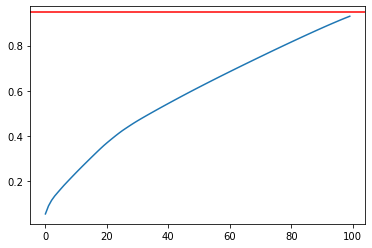

In [30]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

In [72]:
df.shape

(233154, 37)

In [1]:
from sklearn.utils import resample

In [19]:
not_default = df[df.loan_default==0]
default = df[df.loan_default==1]

In [20]:
not_default_downsampled = resample(not_default,
                                replace = True, # sample without replacement
                                n_samples = len(default), # match minority n
                                random_state = 0)

In [21]:
downsampled = pd.concat([not_default_downsampled, default])

In [22]:
y=downsampled['loan_default']
X=downsampled.drop(['loan_default'],axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [24]:
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [31]:
results = []
for item in classifiers:
    print(item,"\n")
    clf = item
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    #print(y_pred)
    #results.append(accuracy_score(y_test,y_pred))
    results.append(y_pred)
    print("accuracy train:",clf.score(X_train,y_train),"\n")
    print("accuracy test:",clf.score(X_test,y_test),"\n")
    print("precision :",precision_score(y_test,y_pred),"\n")
    print('Recall score:',recall_score(y_test,y_pred),'\n')
    print("f1 score:",f1_score(y_test,y_pred),"\n")
    from sklearn.metrics import classification_report
    print(classification_report(y_test,y_pred))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

accuracy train: 0.5980241337943688 

accuracy test: 0.5992689432607765 

precision : 0.5894534071755357 

Recall score: 0.6467208242520309 

f1 score: 0.616760621043681 

              precision    recall  f1-score   support

           0       0.61      0.55      0.58     15226
           1       0.59      0.65      0.62     15141

    accuracy                           0.60     30367
   macro avg       0.60      0.60      0.60     30367
weighted avg       0.60      0.60      0.60     30367

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                 

In [38]:
y_test.value_counts()

0    54756
1    15191
Name: loan_default, dtype: int64

In [40]:
d=pd.concat([X_test,y_test],axis=1)

In [42]:
d.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'branch_id', 'supplier_id',
       'manufacturer_id', 'Current_pincode_ID', 'State_ID', 'Employee_code_ID',
       'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'Passport_flag', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'sub_risk_label',
       'employment_label', 'Age', 'loan_default'],
      dtype='object')

In [45]:
d[d['loan_default']==1]['disbursed_amount'].median()

55553.0

In [46]:
d['disbursed_amount'].median()

53728.0